# Functionally align representations across neural networks

This is a reimplementation of https://colab.research.google.com/github/qihongl/demo-nnalign/blob/master/demo-nnalign.ipynb. Most of the text is left as-is.

----------------------------------------------------------------------

Here's a one sentence summary of the result: 
- different neural networks with the same learning experience acquire representations of the same "shape"

The goal of this script is to demonstrate the point above, by...
- training two networks on the same task 
- then show that i) they have the same "shape"; ii) they are mis-aligned 
- align their representations

In [1]:
from brainiaksrm_nompi import SRM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_classification

sns.set(style='white', context='talk', palette='colorblind')
np.random.seed(0)

## 0. Make some simulated data

First of all, we need generate a learning problem to train some neural networks. In this notebook, we will use a "noisy XOR task". The figure below shows the training set. The test set is independently generated. 

In [3]:
def make_xor_data(n_samples=200):
    center_locs = np.array([[1,1],[-1,-1],[1,-1],[-1,1]])
    cluster_std = .4
    n_features = 2
    n_classes = 2
    # gen pts 
    coords, cluster_ids = make_blobs(
        n_features=n_features, 
        n_samples=n_samples, 
        shuffle=False,
        cluster_std=cluster_std, 
        centers=center_locs
    )
    points_per_class = n_samples // n_classes
    class_labels = np.repeat([0,1], points_per_class)
    return coords, class_labels

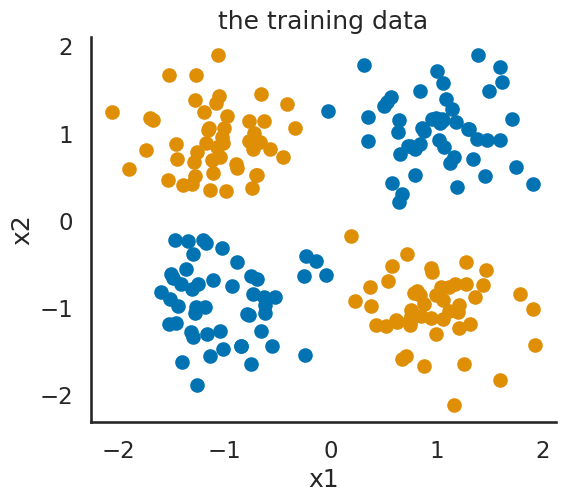

In [4]:
# generate some XOR data
n_examples = 200
x_train, y_train = make_xor_data(n_examples)
x_test, y_test = make_xor_data(n_examples)

# plot the data 
cur_palette = sns.color_palette(n_colors=2)

f, ax = plt.subplots(1,1, figsize=(6,5))
for i, y_val in enumerate(np.unique(y_train)): 
    ax.scatter(
        x_train[y_val == y_train,0],x_train[y_val == y_train,1], 
        color=cur_palette[i], 
    )
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('the training data')
sns.despine()

## 1. Train some neural networks on a common training set

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [23]:
torch.__version__

'2.5.1+cu121'

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.Tanh()
        )
        self.output = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden(x)
        return self.sigmoid(self.output(x))

    def get_hidden_activations(self, x):
        return self.hidden(x)

In [7]:
from tqdm import tqdm

In [8]:
def train_model(model, x_train, y_train, x_test, y_test, batch_size=64, n_epochs=500):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Convert data to tensors
    x_train = torch.FloatTensor(x_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    x_test = torch.FloatTensor(x_test).to(device)
    y_test = torch.FloatTensor(y_test).to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    
    train_acc_history = []
    test_acc_history = []
    
    for epoch in tqdm(range(n_epochs), ascii=True, ncols=60):
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
        # Calculate accuracies
        model.eval()
        with torch.no_grad():
            train_preds = (model(x_train) > 0.5).float()
            test_preds = (model(x_test) > 0.5).float()
            
            train_acc = (train_preds.squeeze() == y_train).float().mean()
            test_acc = (test_preds.squeeze() == y_test).float().mean()
            
            train_acc_history.append(train_acc.cpu())
            test_acc_history.append(test_acc.cpu())
    
    return {'accuracy': train_acc_history, 'val_accuracy': test_acc_history}

In [9]:
# Training multiple models
n_hidden = 50
n_nets = 2
models = []
records = []

for i in range(n_nets):
    model_i = SimpleNet(n_hidden)
    record_i = train_model(model_i, x_train, y_train, x_test, y_test)
    models.append(model_i)
    records.append(record_i)

100%|#####################| 500/500 [00:06<00:00, 80.20it/s]


Here's the classification accuracy for both the training set and the test set, just to confirm that these network learned the task reasonably. 

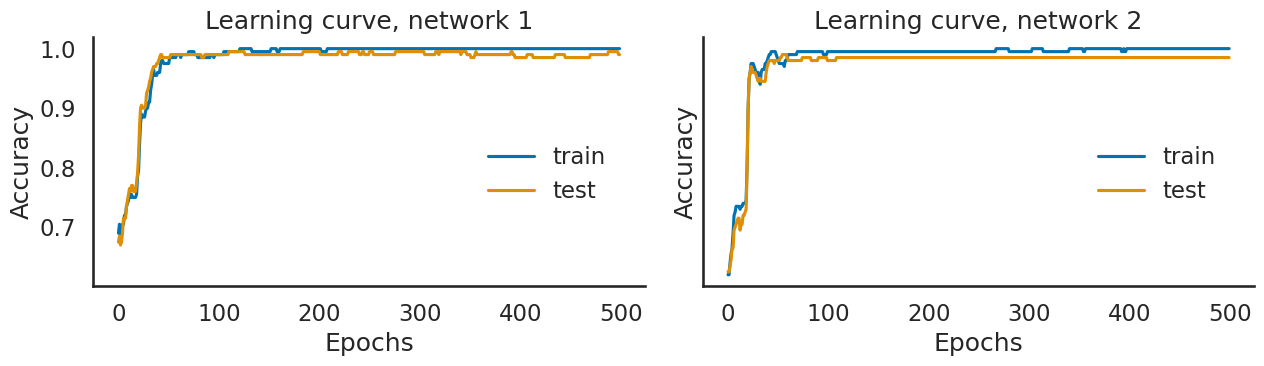

In [10]:
# plot the learning curves
f, axes = plt.subplots(1, n_nets, figsize=(13,4), sharey=True)
for i, ax in enumerate(axes):
    ax.plot(records[i]['accuracy'], label='train')
    ax.plot(records[i]['val_accuracy'], label='test')
    ax.set_title(f'Learning curve, network {i+1}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend(frameon=False, bbox_to_anchor=(.7, .6), loc=2, borderaxespad=0)

sns.despine()
f.tight_layout()

## 2. Some observations

#### Observation 1: "representational similarity matrix (RSM)" are similar across networks


The following figure shows within-subject RSM, which compares the similarity between ... 
- the evoked response of stimulus i in one network 
- the evoked response of stimulus j in **the same** network 

The result shows that the two networks learn basically the same "representational similarity structure". That is, the relation between stimulus i and stimulus j is similar across the two networks. We call this the shared representational structure across these two networks. 

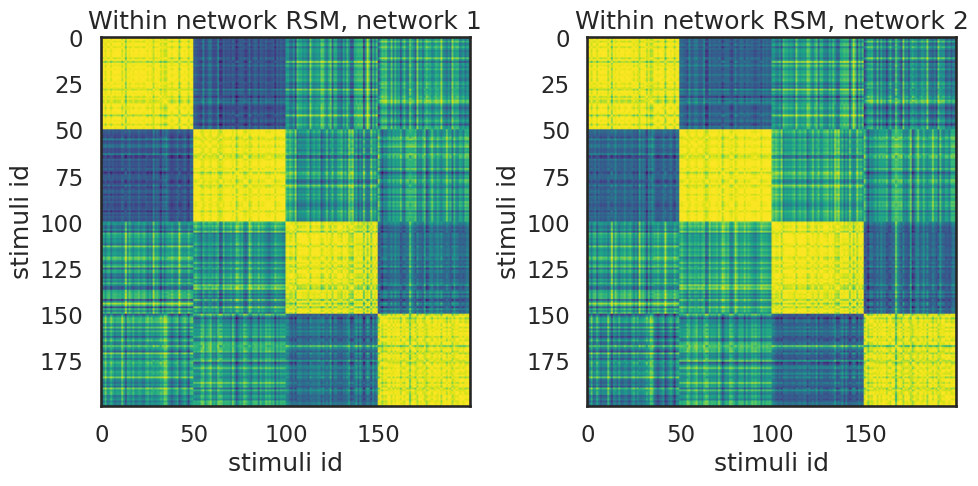

In [11]:
# test the network and get its hidden layer activity 
hidden_act_mats = [model.get_hidden_activations(torch.FloatTensor(x_test).to("cuda")) for model in models]
hidden_act_mats = [h_i.cpu().detach().numpy() for h_i in hidden_act_mats]
within_subject_RSMs = [np.corrcoef(h_i) for h_i in hidden_act_mats]

f,axes = plt.subplots(1, 2, figsize=(10,5))
for i in range(n_nets):
    axes[i].imshow(within_subject_RSMs[i], cmap='viridis')
    axes[i].set_xlabel('stimuli id')
    axes[i].set_ylabel('stimuli id')
    axes[i].set_title(f'Within network RSM, network {i+1}')
f.tight_layout()

In [12]:
# test the network and get its hidden layer activity 
# hidden_act_mats = [get_hidden_act(model, x_test) for model in models]
# within_subject_RSMs = [np.corrcoef(h_i) for h_i in hidden_act_mats]

# f,axes = plt.subplots(1, 2, figsize=(10,5))
# for i in range(n_nets):
#     axes[i].imshow(within_subject_RSMs[i], cmap='viridis')
#     axes[i].set_xlabel('stimuli id')
#     axes[i].set_ylabel('stimuli id')
#     axes[i].set_title(f'Within network RSM, network {i+1}')
# f.tight_layout()

#### Observation 2: however, the same stimulus evokes different response patterns across the two networks

The following figure shows the intersubject RSM in their native spaces, which compares ... 
- the evoked hidden activity pattern of stimulus i from one network 
- the evoked hidden activity pattern of stimulus j from **another** network 

You can see that the following "intersubject" RSM doesn't reflect the representational similarity structure that's shared across the two networks. 

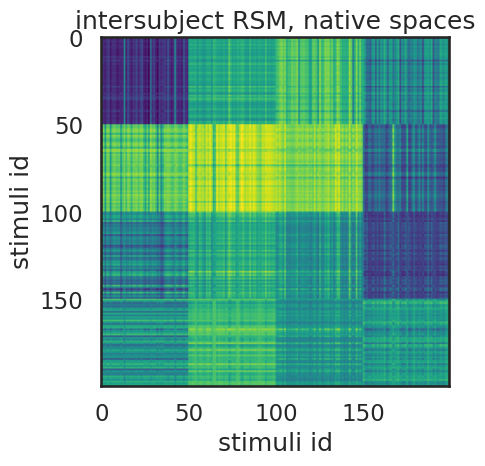

In [13]:
inter_subject_RSM_native = np.corrcoef(
    hidden_act_mats[0],hidden_act_mats[1]
)[:n_examples,n_examples:]

f, ax = plt.subplots(1, 1, figsize=(6,5))

ax.imshow(inter_subject_RSM_native, cmap='viridis')
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')
ax.set_title('intersubject RSM, native spaces')
f.tight_layout()

**Question** So what's similar across these two networks? How do these two networks encode the same similarity structure with different patterns of neural activity? 

**One answer:** We observed that the main reason is that they are misaligned. That is to say, their representational structures really have the same "shape", but oriented differently. Empirically, we show that a rigid-body-transformation (i.e. an orthogonal matrix) is usually enough to align them. 

In the two subject case, we can solve the optimal orthogonal transformation by solving the procrustes problem. However, in the more general case of aligning n networks, we can use the shared response model. 

## 3. Align representations across networks with the shared response model (SRM)

The following code blocks provide a minimal example of the SRM alignment pipeline. 

*In practice, the number of components for SRM can be tuned like how you tune PCA (e.g. measure variance explained). 

In [14]:
# step 1
# get neural network activity matrices ... 
h_act_train = [model.get_hidden_activations(torch.FloatTensor(x_train).to("cuda")) for model in models]
h_act_train = [i.cpu().detach().numpy().T for i in h_act_train]

h_act_test = [model.get_hidden_activations(torch.FloatTensor(x_test).to("cuda")) for model in models]
h_act_test = [i.cpu().detach().numpy().T for i in h_act_test]

In [15]:
# step 2: normalize the data 
for i in range(n_nets): 
    sscalar = StandardScaler()
    sscalar.fit(h_act_train[i])
    h_act_train[i] = sscalar.transform(h_act_train[i])
    h_act_test[i] = sscalar.transform(h_act_test[i])

In [16]:
# step 3: fit SRM
n_components = n_hidden
srm = SRM(features=n_components)
# train SRM on the training set 
h_act_train_shared = srm.fit_transform(h_act_train)
# use the trained SRM to transform the test set activity
h_act_test_shared = srm.transform(h_act_test)

Once aligned, the intersubject RSM is become similar to the within-subject RSM. 

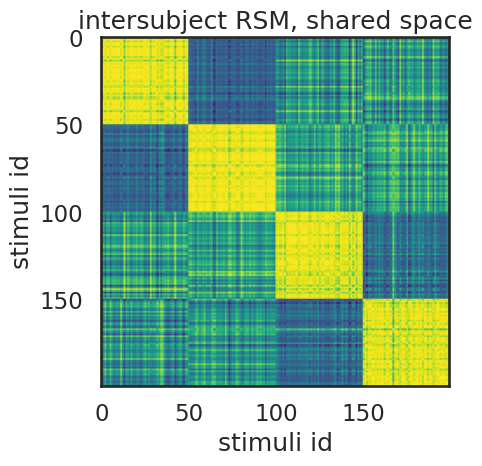

In [17]:
# compute inter-subject RSM in for the transformed activities (in the shared space)
inter_subject_RSM_shared = np.corrcoef(
    h_act_test_shared[0].T,h_act_test_shared[1].T
)[:n_examples,n_examples:]

f, ax = plt.subplots(1, 1, figsize=(6,5))

ax.imshow(inter_subject_RSM_shared, cmap='viridis')
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')
ax.set_title('intersubject RSM, shared space')
f.tight_layout()

We can put the three matrices ... 
- intersubject RSM in the shared space 
- averaged within-subject RSM
- intersubject RSM in the native space

... side by side. This is similar to Fig 2B in the paper. 

Again the point is that, **once aligned in some common space, the intersubject RSM is similar to the within-subject RSM**. In other words, although both stimulus i and stimulus j evoke different responses across these two networks, the relation between stimulus i and stimulus j is represented similarity (across these two networks). 

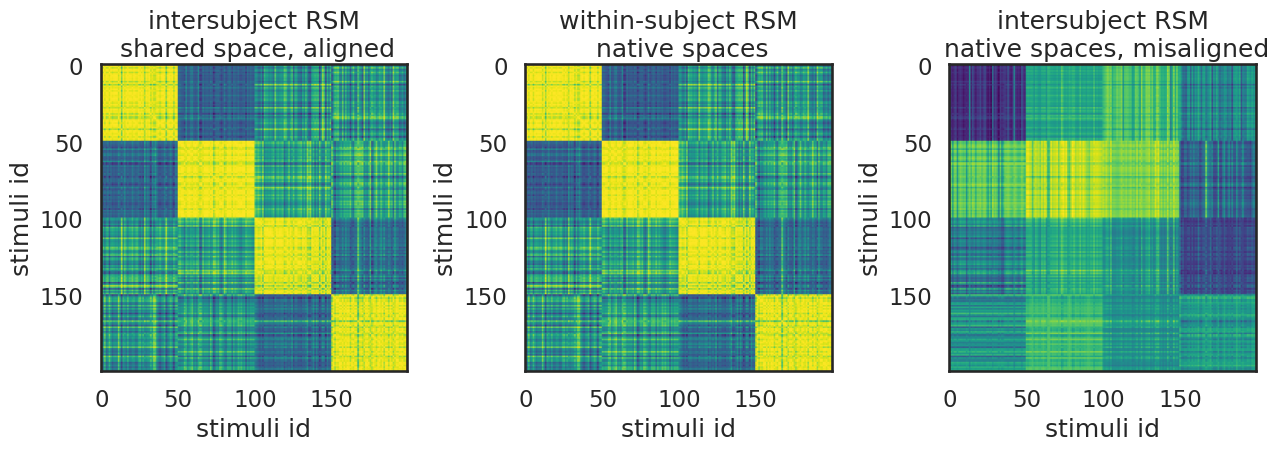

In [18]:
# put the 3 matrices side by side 
titles = [
    'intersubject RSM\n shared space, aligned', 
    'within-subject RSM\n native spaces', 
    'intersubject RSM\n native spaces, misaligned'
]
mats = [
    inter_subject_RSM_shared, 
    np.mean(within_subject_RSMs,axis=0), 
    inter_subject_RSM_native
]

f, axes = plt.subplots(1, 3, figsize=(13,5))
for i,ax in enumerate(axes): 
    ax.imshow(mats[i], cmap='viridis')
    ax.set_title(titles[i])
    ax.set_xlabel('stimuli id')
    ax.set_ylabel('stimuli id')
f.tight_layout()